<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Семинар. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

C:\Users\PTyCCa\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
DATA_DIR = "C:/Users/PTyCCa/Downloads/faces"

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Подготовим наши изображения к дальнейшему использованию

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Посмотрим, как выглядит батч

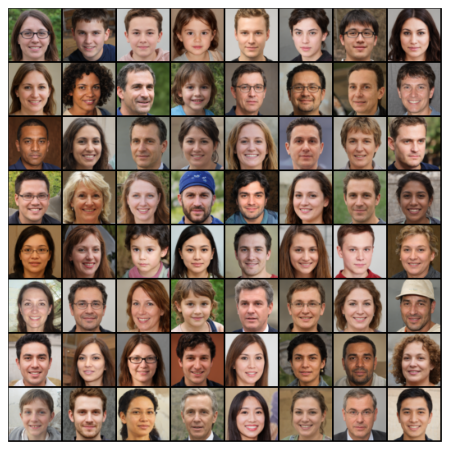

In [ ]:
show_batch(train_dl)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

Давайте перейдем непосредственно к построению GANа. Напомним, что GAN состоит из двух сетей: *генератора*, задача которого – научиться генерировать изображения, похожие на обучающую выборку, из случайного шума, и *дискриминатора*, который учится распознавать, настоящее это изображение или сгенерированное генератором.

Построим генератор и дискриминатор на свертках:

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Посмотрим, как выглядит шум, из которого будут генерироваться изображения

torch.Size([128, 3, 64, 64])


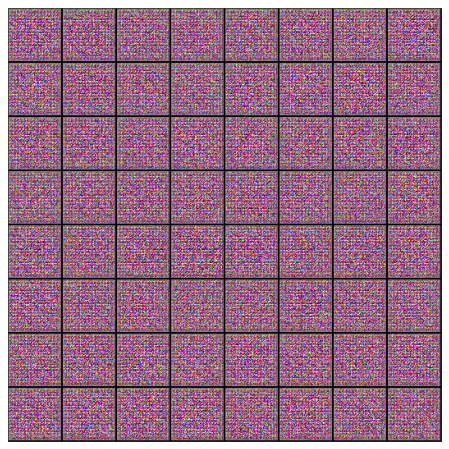

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 100

In [ ]:
history = fit(model, criterion, epochs, lr)

100%|██████████| 79/79 [01:32<00:00,  1.17s/it]


Epoch [1/100], loss_g: 10.8549, loss_d: 0.2258, real_score: 0.9609, fake_score: 0.0845


100%|██████████| 79/79 [01:32<00:00,  1.17s/it]


Epoch [2/100], loss_g: 8.1879, loss_d: 0.1314, real_score: 0.9579, fake_score: 0.0495


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [3/100], loss_g: 7.0635, loss_d: 0.6713, real_score: 0.8816, fake_score: 0.0987


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [4/100], loss_g: 5.2706, loss_d: 0.5791, real_score: 0.8332, fake_score: 0.1690


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [5/100], loss_g: 5.5397, loss_d: 0.6577, real_score: 0.8158, fake_score: 0.1789


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [6/100], loss_g: 4.7700, loss_d: 0.5276, real_score: 0.8353, fake_score: 0.1736


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [7/100], loss_g: 5.0911, loss_d: 0.4350, real_score: 0.8519, fake_score: 0.1486


100%|██████████| 79/79 [01:35<00:00,  1.20s/it]


Epoch [8/100], loss_g: 4.8734, loss_d: 0.5453, real_score: 0.8313, fake_score: 0.1648


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [9/100], loss_g: 4.3263, loss_d: 0.6019, real_score: 0.8102, fake_score: 0.1926


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [10/100], loss_g: 4.1845, loss_d: 0.5349, real_score: 0.8254, fake_score: 0.1753


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [11/100], loss_g: 4.0334, loss_d: 0.5330, real_score: 0.8222, fake_score: 0.1780


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [12/100], loss_g: 3.8588, loss_d: 0.5764, real_score: 0.8302, fake_score: 0.1703


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [13/100], loss_g: 3.5666, loss_d: 0.6141, real_score: 0.7959, fake_score: 0.2027


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [14/100], loss_g: 3.3733, loss_d: 0.5306, real_score: 0.8069, fake_score: 0.1886


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [15/100], loss_g: 3.5822, loss_d: 0.5881, real_score: 0.8123, fake_score: 0.1863


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [16/100], loss_g: 3.4517, loss_d: 0.6154, real_score: 0.7926, fake_score: 0.2068


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [17/100], loss_g: 3.4282, loss_d: 0.5611, real_score: 0.8118, fake_score: 0.1892


100%|██████████| 79/79 [01:35<00:00,  1.21s/it]


Epoch [18/100], loss_g: 3.2904, loss_d: 0.5691, real_score: 0.7998, fake_score: 0.1985


100%|██████████| 79/79 [01:35<00:00,  1.20s/it]


Epoch [19/100], loss_g: 3.3173, loss_d: 0.5355, real_score: 0.8196, fake_score: 0.1804


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [20/100], loss_g: 3.3202, loss_d: 0.5492, real_score: 0.8066, fake_score: 0.1908


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [21/100], loss_g: 3.3504, loss_d: 0.5233, real_score: 0.8196, fake_score: 0.1804


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [22/100], loss_g: 3.4800, loss_d: 0.4834, real_score: 0.8218, fake_score: 0.1734


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [23/100], loss_g: 3.4880, loss_d: 0.4566, real_score: 0.8433, fake_score: 0.1629


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [24/100], loss_g: 3.4966, loss_d: 0.5145, real_score: 0.8272, fake_score: 0.1716


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [25/100], loss_g: 3.5084, loss_d: 0.5623, real_score: 0.8207, fake_score: 0.1770


100%|██████████| 79/79 [01:33<00:00,  1.19s/it]


Epoch [26/100], loss_g: 3.4873, loss_d: 0.4866, real_score: 0.8351, fake_score: 0.1647


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [27/100], loss_g: 3.4605, loss_d: 0.5057, real_score: 0.8372, fake_score: 0.1607


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [28/100], loss_g: 3.4614, loss_d: 0.4635, real_score: 0.8311, fake_score: 0.1677


100%|██████████| 79/79 [01:33<00:00,  1.19s/it]


Epoch [29/100], loss_g: 3.5804, loss_d: 0.4218, real_score: 0.8496, fake_score: 0.1496


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [30/100], loss_g: 3.8768, loss_d: 0.3670, real_score: 0.8812, fake_score: 0.1188


100%|██████████| 79/79 [01:33<00:00,  1.19s/it]


Epoch [31/100], loss_g: 3.5570, loss_d: 0.4329, real_score: 0.8429, fake_score: 0.1567


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [32/100], loss_g: 3.5831, loss_d: 0.4270, real_score: 0.8575, fake_score: 0.1398


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [33/100], loss_g: 3.6588, loss_d: 0.5320, real_score: 0.8271, fake_score: 0.1752


100%|██████████| 79/79 [01:33<00:00,  1.19s/it]


Epoch [34/100], loss_g: 3.7468, loss_d: 0.4610, real_score: 0.8547, fake_score: 0.1449


100%|██████████| 79/79 [01:33<00:00,  1.19s/it]


Epoch [35/100], loss_g: 3.7486, loss_d: 0.4979, real_score: 0.8348, fake_score: 0.1623


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [36/100], loss_g: 3.5793, loss_d: 0.2587, real_score: 0.8940, fake_score: 0.1067


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch [37/100], loss_g: 3.8668, loss_d: 0.4579, real_score: 0.8501, fake_score: 0.1476


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [38/100], loss_g: 3.7550, loss_d: 0.3398, real_score: 0.8909, fake_score: 0.1104


100%|██████████| 79/79 [01:33<00:00,  1.19s/it]


Epoch [39/100], loss_g: 3.7261, loss_d: 0.5691, real_score: 0.8311, fake_score: 0.1680


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [40/100], loss_g: 3.6353, loss_d: 0.3347, real_score: 0.8748, fake_score: 0.1240


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [41/100], loss_g: 3.8580, loss_d: 0.4991, real_score: 0.8583, fake_score: 0.1389


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [42/100], loss_g: 3.6939, loss_d: 0.3827, real_score: 0.8632, fake_score: 0.1438


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [43/100], loss_g: 3.7793, loss_d: 0.3326, real_score: 0.8721, fake_score: 0.1211


100%|██████████| 79/79 [01:33<00:00,  1.19s/it]


Epoch [44/100], loss_g: 4.0169, loss_d: 0.4363, real_score: 0.8640, fake_score: 0.1367


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [45/100], loss_g: 3.9509, loss_d: 0.3836, real_score: 0.8664, fake_score: 0.1310


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [46/100], loss_g: 3.9685, loss_d: 0.3446, real_score: 0.8920, fake_score: 0.1091


100%|██████████| 79/79 [01:33<00:00,  1.19s/it]


Epoch [47/100], loss_g: 3.7541, loss_d: 0.3452, real_score: 0.8857, fake_score: 0.1153


100%|██████████| 79/79 [01:33<00:00,  1.19s/it]


Epoch [48/100], loss_g: 4.0622, loss_d: 0.3301, real_score: 0.8975, fake_score: 0.1001


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch [49/100], loss_g: 3.8708, loss_d: 0.3024, real_score: 0.8892, fake_score: 0.1096


100%|██████████| 79/79 [01:40<00:00,  1.27s/it]


Epoch [50/100], loss_g: 3.7464, loss_d: 0.5556, real_score: 0.8468, fake_score: 0.1543


100%|██████████| 79/79 [01:39<00:00,  1.26s/it]


Epoch [51/100], loss_g: 3.9329, loss_d: 0.3050, real_score: 0.9001, fake_score: 0.0981


100%|██████████| 79/79 [01:43<00:00,  1.32s/it]


Epoch [52/100], loss_g: 3.9092, loss_d: 0.2899, real_score: 0.9009, fake_score: 0.1007


100%|██████████| 79/79 [01:45<00:00,  1.34s/it]


Epoch [53/100], loss_g: 4.0045, loss_d: 0.3549, real_score: 0.8811, fake_score: 0.1179


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [54/100], loss_g: 4.0913, loss_d: 0.4896, real_score: 0.8657, fake_score: 0.1349


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [55/100], loss_g: 3.7622, loss_d: 0.3730, real_score: 0.8665, fake_score: 0.1311


100%|██████████| 79/79 [01:48<00:00,  1.37s/it]


Epoch [56/100], loss_g: 3.9427, loss_d: 0.2931, real_score: 0.8926, fake_score: 0.1062


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [57/100], loss_g: 4.0902, loss_d: 0.4002, real_score: 0.8787, fake_score: 0.1229


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [58/100], loss_g: 3.9018, loss_d: 0.2804, real_score: 0.8980, fake_score: 0.1008


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [59/100], loss_g: 4.1758, loss_d: 0.3785, real_score: 0.8977, fake_score: 0.0984


100%|██████████| 79/79 [01:47<00:00,  1.37s/it]


Epoch [60/100], loss_g: 4.0301, loss_d: 0.3055, real_score: 0.8824, fake_score: 0.1171


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [61/100], loss_g: 4.1167, loss_d: 0.3548, real_score: 0.8908, fake_score: 0.1097


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [62/100], loss_g: 4.0619, loss_d: 0.1810, real_score: 0.9235, fake_score: 0.0781


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [63/100], loss_g: 4.0360, loss_d: 0.4241, real_score: 0.8752, fake_score: 0.1259


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [64/100], loss_g: 4.0049, loss_d: 0.3891, real_score: 0.8803, fake_score: 0.1169


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [65/100], loss_g: 3.9662, loss_d: 0.4767, real_score: 0.8591, fake_score: 0.1419


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [66/100], loss_g: 4.0966, loss_d: 0.1488, real_score: 0.9346, fake_score: 0.0657


100%|██████████| 79/79 [01:40<00:00,  1.27s/it]


Epoch [67/100], loss_g: 4.3458, loss_d: 0.3653, real_score: 0.9080, fake_score: 0.0918


100%|██████████| 79/79 [01:40<00:00,  1.28s/it]


Epoch [68/100], loss_g: 4.0933, loss_d: 0.3733, real_score: 0.8825, fake_score: 0.1163


100%|██████████| 79/79 [01:42<00:00,  1.29s/it]


Epoch [69/100], loss_g: 4.0595, loss_d: 0.3571, real_score: 0.8956, fake_score: 0.1051


100%|██████████| 79/79 [01:42<00:00,  1.29s/it]


Epoch [70/100], loss_g: 3.9751, loss_d: 0.3742, real_score: 0.8934, fake_score: 0.1033


100%|██████████| 79/79 [01:41<00:00,  1.29s/it]


Epoch [71/100], loss_g: 4.1208, loss_d: 0.4597, real_score: 0.8490, fake_score: 0.1508


100%|██████████| 79/79 [01:42<00:00,  1.30s/it]


Epoch [72/100], loss_g: 3.8219, loss_d: 0.2328, real_score: 0.9130, fake_score: 0.0891


100%|██████████| 79/79 [01:41<00:00,  1.28s/it]


Epoch [73/100], loss_g: 3.9269, loss_d: 0.3388, real_score: 0.8876, fake_score: 0.1116


100%|██████████| 79/79 [01:42<00:00,  1.30s/it]


Epoch [74/100], loss_g: 4.2613, loss_d: 0.2728, real_score: 0.9140, fake_score: 0.0858


100%|██████████| 79/79 [01:45<00:00,  1.34s/it]


Epoch [75/100], loss_g: 4.2954, loss_d: 0.2337, real_score: 0.9314, fake_score: 0.0641


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [76/100], loss_g: 4.0907, loss_d: 0.3497, real_score: 0.8986, fake_score: 0.1036


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [77/100], loss_g: 4.0446, loss_d: 0.3275, real_score: 0.8915, fake_score: 0.1045


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [78/100], loss_g: 4.1733, loss_d: 0.3156, real_score: 0.8939, fake_score: 0.1100


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [79/100], loss_g: 4.1684, loss_d: 0.3124, real_score: 0.8932, fake_score: 0.1074


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [80/100], loss_g: 4.2757, loss_d: 0.0847, real_score: 0.9605, fake_score: 0.0399


100%|██████████| 79/79 [01:47<00:00,  1.37s/it]


Epoch [81/100], loss_g: 4.5764, loss_d: 0.2358, real_score: 0.9273, fake_score: 0.0709


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [82/100], loss_g: 4.4003, loss_d: 0.3252, real_score: 0.8989, fake_score: 0.1009


100%|██████████| 79/79 [01:48<00:00,  1.37s/it]


Epoch [83/100], loss_g: 4.3183, loss_d: 0.2203, real_score: 0.9177, fake_score: 0.0838


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [84/100], loss_g: 4.1287, loss_d: 0.4438, real_score: 0.8745, fake_score: 0.1248


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [85/100], loss_g: 4.2036, loss_d: 0.1975, real_score: 0.9229, fake_score: 0.0769


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [86/100], loss_g: 4.3696, loss_d: 0.4571, real_score: 0.8838, fake_score: 0.1160


100%|██████████| 79/79 [01:40<00:00,  1.27s/it]


Epoch [87/100], loss_g: 4.1820, loss_d: 0.1713, real_score: 0.9278, fake_score: 0.0726


100%|██████████| 79/79 [01:40<00:00,  1.27s/it]


Epoch [88/100], loss_g: 4.4286, loss_d: 0.1184, real_score: 0.9475, fake_score: 0.0506


100%|██████████| 79/79 [01:41<00:00,  1.29s/it]


Epoch [89/100], loss_g: 4.6279, loss_d: 0.4179, real_score: 0.8791, fake_score: 0.1214


100%|██████████| 79/79 [01:41<00:00,  1.29s/it]


Epoch [90/100], loss_g: 4.3547, loss_d: 0.1089, real_score: 0.9502, fake_score: 0.0495


100%|██████████| 79/79 [01:41<00:00,  1.28s/it]


Epoch [91/100], loss_g: 4.1981, loss_d: 0.3129, real_score: 0.9095, fake_score: 0.0901


100%|██████████| 79/79 [01:40<00:00,  1.27s/it]


Epoch [92/100], loss_g: 4.4568, loss_d: 0.3382, real_score: 0.9043, fake_score: 0.0956


100%|██████████| 79/79 [01:41<00:00,  1.28s/it]


Epoch [93/100], loss_g: 4.2432, loss_d: 0.4144, real_score: 0.8855, fake_score: 0.1142


100%|██████████| 79/79 [01:41<00:00,  1.28s/it]


Epoch [94/100], loss_g: 4.1322, loss_d: 0.2951, real_score: 0.9072, fake_score: 0.0904


100%|██████████| 79/79 [01:46<00:00,  1.34s/it]


Epoch [95/100], loss_g: 3.9216, loss_d: 0.1827, real_score: 0.9195, fake_score: 0.0773


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [96/100], loss_g: 4.1138, loss_d: 0.5945, real_score: 0.8417, fake_score: 0.1611


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [97/100], loss_g: 4.2081, loss_d: 0.1451, real_score: 0.9374, fake_score: 0.0646


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [98/100], loss_g: 4.2442, loss_d: 0.1403, real_score: 0.9419, fake_score: 0.0585


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [99/100], loss_g: 4.4122, loss_d: 0.3251, real_score: 0.9211, fake_score: 0.0753


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]

Epoch [100/100], loss_g: 4.2485, loss_d: 0.2816, real_score: 0.9020, fake_score: 0.0998
Saving generated-images-0100.png


Посмотрим на результаты обучения. Вот так выглядят лица, сгенерированные на последней эпохе обучения:

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
generated_img = cv2.imread(f'C:/Users/PTyCCa/Downloads/generated/generated-images-0{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

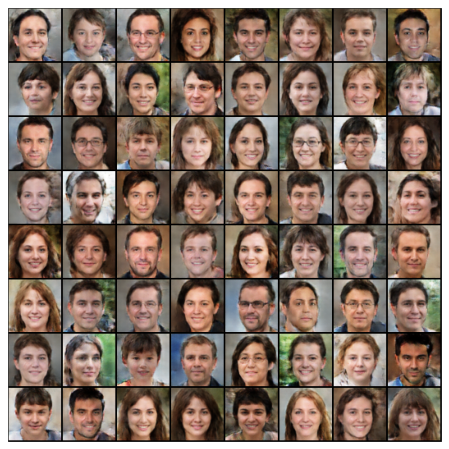

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как мы видим, изображение в целом получается похожим, однако есть много артефактов

Посмотрим на графики loss генератора и дискриминатора и score дискриминатора

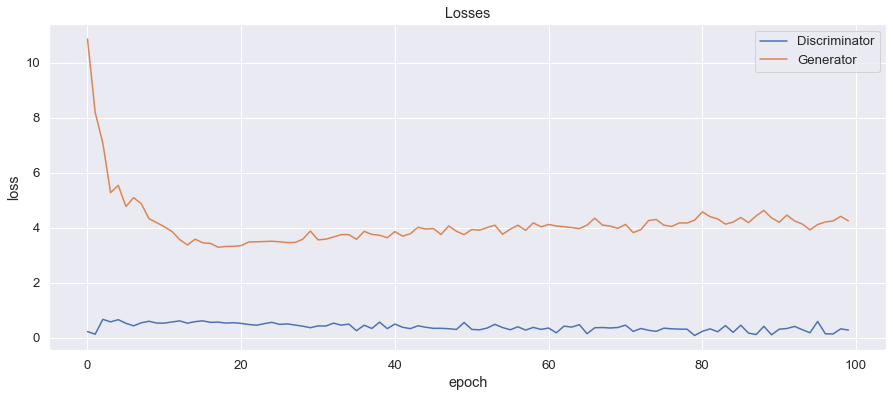

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

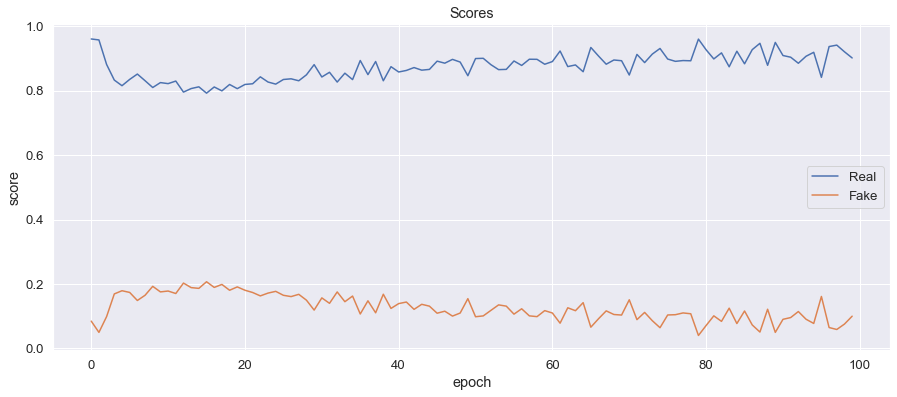

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
def generate(model, size):
    imgs = torch.Tensor()
    model.eval()
    with torch.no_grad():
        while size > 0:
            latent = torch.randn(
                min(size, 16), 128, 1, 1, device=device
            )
            imgs = torch.cat([imgs, model(latent).cpu()])
            size = size - 16
    return imgs

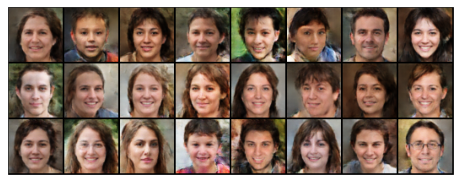

In [ ]:
N_IMAGES = 24
show_images(generate(model['generator'], N_IMAGES))

Как вам качество получившихся изображений?

В целом похоже, но достаточно много артефактов.

## Построение и обучение модели (Ver II)

Попробуем взять больший исходный размер изображений и чуть изменим наши модели.  
Так же увеличим количество эпох.  
Обучение данной модели будем производить на локальном GPU, так как мощностей Google Colab недостаточно для завершения процессов.

### Импорты и установка библиотек

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tfs
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import tqdm
import pickle
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score

C:\Users\PTyCCa\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from tqdm import tqdm

### Вспомогательные функции

In [ ]:
def show_images(imgs, size=(8, 8)):
    fig, ax = plt.subplots(figsize=(size[0]*2, size[1]*2))
    ax.set_xticks([])
    ax.set_yticks([])
    nmax = size[0] * size[1]
    ax.imshow(
        make_grid(imgs[:nmax], nrow=size[0]).permute(1, 2, 0)
    )

In [ ]:
def show_history(history):
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS+1), history[0]['generator'], label='generator')
    plt.plot(range(1, EPOCHS+1), history[0]['discriminator'], label='discriminator')
    plt.legend(loc='lower right')
    plt.title('BCE Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS+1), history[1]['real'], label='real')
    plt.plot(range(1, EPOCHS+1), history[1]['fake'], label='fake')
    plt.legend(loc='upper left')
    plt.title('Accuracy')

    plt.show()

In [ ]:
def generate(model, size):
    imgs = torch.Tensor()
    model.eval()
    with torch.no_grad():
        while size > 0:
            latent = torch.randn(
                min(size, BATCH_SIZE), LATENT_SIZE, 1, 1, device=DEVICE
            )
            imgs = torch.cat([imgs, model(latent).cpu()])
            size = size - BATCH_SIZE
    return imgs

### Подготовка данных

In [ ]:
DATA_DIR = 'C:/Users/PTyCCa/Downloads/faces'
DATA_OUT = 'C:/Users/PTyCCa/Downloads/faces/gen'
#NORMS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
BATCH_SIZE = 128
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tfs.Compose([
    tfs.Resize(128),
    tfs.CenterCrop(128),
    tfs.ToTensor(),
    ])) #tfs.Normalize(*NORMS)

In [ ]:
dataloader = DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)

Взглянем на часть нашего датасета

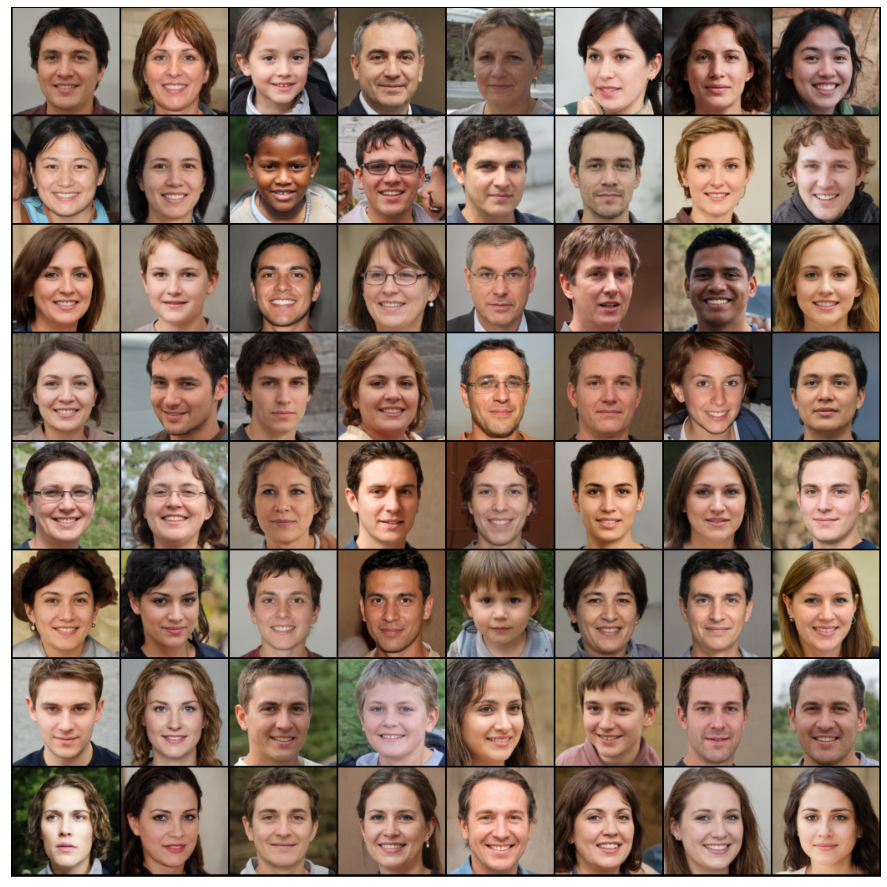

In [ ]:
test_imgs, _ = next(iter(dataloader))
show_images(test_imgs)

### Построение и обучение модели

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 64 x 64

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()

).to(DEVICE)

In [ ]:
LATENT_SIZE = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # nn.Dropout(0.5),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # nn.Dropout(0.5),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # nn.Dropout(0.5),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # nn.Dropout(0.5),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # nn.Dropout(0.5),
    # out: 64 x 64 x 64

    # nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, bias=False),
    # nn.BatchNorm2d(32),
    # nn.ReLU(True),
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128

).to(DEVICE)    

In [ ]:
LR = 0.0002

model = {
    'discriminator': discriminator,
    'generator': generator
}

criterion = {
    'discriminator': nn.BCELoss(),
    'generator': nn.BCELoss()
}

optimizer = {
    'discriminator': Adam(
        model['discriminator'].parameters(), lr=LR, betas=(0.5, 0.999)
    ),
    'generator': Adam(
        model['generator'].parameters(), lr=LR, betas=(0.5, 0.999)
    )
}

In [ ]:
def fit(model, criterion, optimizer, epochs, save_results = False):
    # Losses & scores
    losses = {
        'discriminator': [],
        'generator': []
    }
    scores = {
        'real': [],
        'fake': []
    }

    for epoch in range(epochs):
        loss_per_epoch = {
            'discriminator': [],
            'generator': []
        }
        score_per_epoch = {
            'real': [],
            'fake': []
        }
        
        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(DEVICE)

            # Train discriminator

            # Clear discriminator gradients
            optimizer['discriminator'].zero_grad()
            
            # Pass real images through discriminator
            real_preds = model['discriminator'](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=DEVICE)
            real_loss = criterion['discriminator'](real_preds, real_targets)
            real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=DEVICE)
            fake_images = model['generator'](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(BATCH_SIZE, 1, device=DEVICE)
            fake_preds = model['discriminator'](fake_images)
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds).item()

            score_per_epoch['real'].append(real_score)
            score_per_epoch['fake'].append(fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer['discriminator'].step()
            loss_per_epoch['discriminator'].append(loss_d.item())

            # Train generator
            
            model['generator'].train()
            
            # Clear generator gradients
            optimizer['generator'].zero_grad()
            
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=DEVICE)
            fake_images = model['generator'](latent)
            
            # Try to fool the discriminator
            preds = model['discriminator'](fake_images)
            targets = torch.ones(BATCH_SIZE, 1, device=DEVICE)
            loss_g = criterion['generator'](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer['generator'].step()
            loss_per_epoch['generator'].append(loss_g.item())
            
        # Record losses & scores
        losses['generator'].append(np.mean(loss_per_epoch['generator']))
        losses['discriminator'].append(np.mean(loss_per_epoch['discriminator']))
        scores['real'].append(np.mean(score_per_epoch['real']))
        scores['fake'].append(np.mean(score_per_epoch['fake']))
        
        # Log losses & scores (last batch)
        print(
            'Epoch [{}/{}], gen_loss: {:.4f}, dis_loss: {:.4f}, '
            'real_score: {:.4f}, fake_score: {:.4f}'.format(
                epoch+1, epochs, 
                losses['generator'][-1], losses['discriminator'][-1],
                scores['real'][-1], scores['fake'][-1]
            )
        )
        
        # Save results
        if save_results and ((epoch+1) in [1, 3, 8, 20, 50, 80, 100, 120, 150]):
            imgs = generate(model['generator'], 1000)
            with open(f'imgs_epoch_{epoch+1}.pkl', 'wb') as handle:
                pickle.dump(imgs, handle, protocol=pickle.HIGHEST_PROTOCOL)
            torch.save(
                model['generator'].state_dict(),
                f'gen_epoch_{epoch+1}.weights'
            )
            torch.save(
                model['discriminator'].state_dict(),
                f'dis_epoch_{epoch+1}.weights'
            )
    
    return losses, scores

In [ ]:
EPOCHS = 150
history = fit(model, criterion, optimizer, EPOCHS, True)

100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Epoch [1/150], gen_loss: 8.9312, dis_loss: 0.0782, real_score: 0.9772, fake_score: 0.0354


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [2/150], gen_loss: 12.7240, dis_loss: 0.2504, real_score: 0.9817, fake_score: 0.0613


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [3/150], gen_loss: 14.6999, dis_loss: 0.0728, real_score: 0.9811, fake_score: 0.0279


100%|██████████| 79/79 [01:46<00:00,  1.34s/it]


Epoch [4/150], gen_loss: 12.2639, dis_loss: 0.3902, real_score: 0.9388, fake_score: 0.0620


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [5/150], gen_loss: 7.0617, dis_loss: 0.7512, real_score: 0.8756, fake_score: 0.0958


100%|██████████| 79/79 [01:52<00:00,  1.42s/it]


Epoch [6/150], gen_loss: 6.1256, dis_loss: 0.3620, real_score: 0.8908, fake_score: 0.1003


100%|██████████| 79/79 [01:51<00:00,  1.42s/it]


Epoch [7/150], gen_loss: 5.8059, dis_loss: 0.3110, real_score: 0.9190, fake_score: 0.0729


100%|██████████| 79/79 [01:52<00:00,  1.42s/it]


Epoch [8/150], gen_loss: 5.8698, dis_loss: 0.2540, real_score: 0.9307, fake_score: 0.0634


100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Epoch [9/150], gen_loss: 5.7248, dis_loss: 0.4774, real_score: 0.8820, fake_score: 0.1152


100%|██████████| 79/79 [01:52<00:00,  1.42s/it]


Epoch [10/150], gen_loss: 3.7340, dis_loss: 0.8136, real_score: 0.7651, fake_score: 0.2246


100%|██████████| 79/79 [01:53<00:00,  1.43s/it]


Epoch [11/150], gen_loss: 4.1756, dis_loss: 0.7164, real_score: 0.7910, fake_score: 0.2263


100%|██████████| 79/79 [01:53<00:00,  1.43s/it]


Epoch [12/150], gen_loss: 4.4205, dis_loss: 0.6594, real_score: 0.8013, fake_score: 0.2038


100%|██████████| 79/79 [01:53<00:00,  1.44s/it]


Epoch [13/150], gen_loss: 4.4746, dis_loss: 0.7097, real_score: 0.7946, fake_score: 0.2149


100%|██████████| 79/79 [01:53<00:00,  1.44s/it]


Epoch [14/150], gen_loss: 4.5432, dis_loss: 0.6850, real_score: 0.7895, fake_score: 0.2057


100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Epoch [15/150], gen_loss: 4.7201, dis_loss: 0.6329, real_score: 0.7995, fake_score: 0.1957


100%|██████████| 79/79 [01:52<00:00,  1.43s/it]


Epoch [16/150], gen_loss: 4.9305, dis_loss: 0.6782, real_score: 0.7975, fake_score: 0.2044


100%|██████████| 79/79 [01:52<00:00,  1.42s/it]


Epoch [17/150], gen_loss: 4.6908, dis_loss: 0.6127, real_score: 0.8094, fake_score: 0.1865


100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Epoch [18/150], gen_loss: 4.5763, dis_loss: 0.5898, real_score: 0.8022, fake_score: 0.2051


100%|██████████| 79/79 [01:52<00:00,  1.42s/it]


Epoch [19/150], gen_loss: 4.2451, dis_loss: 0.6976, real_score: 0.7816, fake_score: 0.2117


100%|██████████| 79/79 [01:52<00:00,  1.42s/it]


Epoch [20/150], gen_loss: 4.0778, dis_loss: 0.6433, real_score: 0.7899, fake_score: 0.2074


100%|██████████| 79/79 [01:52<00:00,  1.43s/it]


Epoch [21/150], gen_loss: 4.0199, dis_loss: 0.6094, real_score: 0.8083, fake_score: 0.1890


100%|██████████| 79/79 [01:52<00:00,  1.42s/it]


Epoch [22/150], gen_loss: 3.8906, dis_loss: 0.6506, real_score: 0.7879, fake_score: 0.2124


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [23/150], gen_loss: 3.6663, dis_loss: 0.6596, real_score: 0.7826, fake_score: 0.2134


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [24/150], gen_loss: 3.6739, dis_loss: 0.6192, real_score: 0.7959, fake_score: 0.2025


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [25/150], gen_loss: 3.6802, dis_loss: 0.6501, real_score: 0.7944, fake_score: 0.2010


100%|██████████| 79/79 [01:42<00:00,  1.30s/it]


Epoch [26/150], gen_loss: 3.5953, dis_loss: 0.5845, real_score: 0.8031, fake_score: 0.1936


100%|██████████| 79/79 [01:42<00:00,  1.30s/it]


Epoch [27/150], gen_loss: 3.7412, dis_loss: 0.6363, real_score: 0.7982, fake_score: 0.2008


100%|██████████| 79/79 [01:42<00:00,  1.30s/it]


Epoch [28/150], gen_loss: 3.5853, dis_loss: 0.5198, real_score: 0.8246, fake_score: 0.1774


100%|██████████| 79/79 [01:42<00:00,  1.30s/it]


Epoch [29/150], gen_loss: 3.8479, dis_loss: 0.5574, real_score: 0.8205, fake_score: 0.1786


100%|██████████| 79/79 [01:42<00:00,  1.30s/it]


Epoch [30/150], gen_loss: 3.9903, dis_loss: 0.5722, real_score: 0.8156, fake_score: 0.1894


100%|██████████| 79/79 [01:46<00:00,  1.34s/it]


Epoch [31/150], gen_loss: 3.9345, dis_loss: 0.5526, real_score: 0.8185, fake_score: 0.1782


100%|██████████| 79/79 [01:45<00:00,  1.34s/it]


Epoch [32/150], gen_loss: 3.9277, dis_loss: 0.5292, real_score: 0.8341, fake_score: 0.1619


100%|██████████| 79/79 [01:48<00:00,  1.37s/it]


Epoch [33/150], gen_loss: 3.9439, dis_loss: 0.4055, real_score: 0.8549, fake_score: 0.1453


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [34/150], gen_loss: 4.1004, dis_loss: 0.5643, real_score: 0.8297, fake_score: 0.1670


100%|██████████| 79/79 [01:48<00:00,  1.37s/it]


Epoch [35/150], gen_loss: 4.0715, dis_loss: 0.4152, real_score: 0.8505, fake_score: 0.1481


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [36/150], gen_loss: 4.0896, dis_loss: 0.4237, real_score: 0.8596, fake_score: 0.1450


100%|██████████| 79/79 [01:48<00:00,  1.37s/it]


Epoch [37/150], gen_loss: 4.3388, dis_loss: 0.4434, real_score: 0.8496, fake_score: 0.1477


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [38/150], gen_loss: 3.9805, dis_loss: 0.4500, real_score: 0.8652, fake_score: 0.1312


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [39/150], gen_loss: 4.3313, dis_loss: 0.5145, real_score: 0.8421, fake_score: 0.1576


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [40/150], gen_loss: 4.0508, dis_loss: 0.3388, real_score: 0.8711, fake_score: 0.1294


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [41/150], gen_loss: 4.1552, dis_loss: 0.5690, real_score: 0.8433, fake_score: 0.1592


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [42/150], gen_loss: 4.1457, dis_loss: 0.4570, real_score: 0.8519, fake_score: 0.1388


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [43/150], gen_loss: 4.0284, dis_loss: 0.3564, real_score: 0.8755, fake_score: 0.1299


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [44/150], gen_loss: 4.2257, dis_loss: 0.4303, real_score: 0.8678, fake_score: 0.1308


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [45/150], gen_loss: 4.2128, dis_loss: 0.4680, real_score: 0.8646, fake_score: 0.1301


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [46/150], gen_loss: 4.1726, dis_loss: 0.3492, real_score: 0.8809, fake_score: 0.1253


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [47/150], gen_loss: 4.3694, dis_loss: 0.4124, real_score: 0.8638, fake_score: 0.1327


100%|██████████| 79/79 [01:43<00:00,  1.30s/it]


Epoch [48/150], gen_loss: 4.4122, dis_loss: 0.4547, real_score: 0.8618, fake_score: 0.1357


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [49/150], gen_loss: 4.1537, dis_loss: 0.3747, real_score: 0.8784, fake_score: 0.1133


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [50/150], gen_loss: 4.3163, dis_loss: 0.3838, real_score: 0.8774, fake_score: 0.1333


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [51/150], gen_loss: 4.3525, dis_loss: 0.4044, real_score: 0.8794, fake_score: 0.1210


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [52/150], gen_loss: 4.4332, dis_loss: 0.3909, real_score: 0.8777, fake_score: 0.1180


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [53/150], gen_loss: 4.2127, dis_loss: 0.2934, real_score: 0.8979, fake_score: 0.1015


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [54/150], gen_loss: 4.3923, dis_loss: 0.4299, real_score: 0.8698, fake_score: 0.1296


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [55/150], gen_loss: 4.3929, dis_loss: 0.3713, real_score: 0.8844, fake_score: 0.1168


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [56/150], gen_loss: 4.2965, dis_loss: 0.3966, real_score: 0.8741, fake_score: 0.1206


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [57/150], gen_loss: 4.3022, dis_loss: 0.3953, real_score: 0.8812, fake_score: 0.1214


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [58/150], gen_loss: 4.3521, dis_loss: 0.3419, real_score: 0.9010, fake_score: 0.0997


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [59/150], gen_loss: 4.3878, dis_loss: 0.4071, real_score: 0.8805, fake_score: 0.1157


100%|██████████| 79/79 [01:46<00:00,  1.34s/it]


Epoch [60/150], gen_loss: 4.4042, dis_loss: 0.3675, real_score: 0.8881, fake_score: 0.1136


100%|██████████| 79/79 [01:42<00:00,  1.30s/it]


Epoch [61/150], gen_loss: 4.5687, dis_loss: 0.4273, real_score: 0.8696, fake_score: 0.1325


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [62/150], gen_loss: 4.3783, dis_loss: 0.2825, real_score: 0.8989, fake_score: 0.0993


100%|██████████| 79/79 [01:48<00:00,  1.37s/it]


Epoch [63/150], gen_loss: 4.6842, dis_loss: 0.3926, real_score: 0.8788, fake_score: 0.1196


100%|██████████| 79/79 [01:48<00:00,  1.37s/it]


Epoch [64/150], gen_loss: 4.4752, dis_loss: 0.2666, real_score: 0.9053, fake_score: 0.0936


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [65/150], gen_loss: 4.7610, dis_loss: 0.4301, real_score: 0.8817, fake_score: 0.1130


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [66/150], gen_loss: 4.4395, dis_loss: 0.2989, real_score: 0.8994, fake_score: 0.1078


100%|██████████| 79/79 [01:48<00:00,  1.37s/it]


Epoch [67/150], gen_loss: 4.5816, dis_loss: 0.3343, real_score: 0.8944, fake_score: 0.1041


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [68/150], gen_loss: 4.4705, dis_loss: 0.3365, real_score: 0.8931, fake_score: 0.1028


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [69/150], gen_loss: 4.8657, dis_loss: 0.3868, real_score: 0.8791, fake_score: 0.1186


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [70/150], gen_loss: 4.4621, dis_loss: 0.4206, real_score: 0.8840, fake_score: 0.1187


100%|██████████| 79/79 [01:48<00:00,  1.37s/it]


Epoch [71/150], gen_loss: 4.4370, dis_loss: 0.3252, real_score: 0.8989, fake_score: 0.1033


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch [72/150], gen_loss: 4.4131, dis_loss: 0.4067, real_score: 0.8971, fake_score: 0.0997


100%|██████████| 79/79 [01:48<00:00,  1.37s/it]


Epoch [73/150], gen_loss: 4.3238, dis_loss: 0.2989, real_score: 0.9002, fake_score: 0.1022


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [74/150], gen_loss: 4.4315, dis_loss: 0.2912, real_score: 0.8991, fake_score: 0.0970


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [75/150], gen_loss: 4.7268, dis_loss: 0.2690, real_score: 0.9096, fake_score: 0.0925


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [76/150], gen_loss: 4.4460, dis_loss: 0.3807, real_score: 0.8862, fake_score: 0.1127


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [77/150], gen_loss: 4.6067, dis_loss: 0.4299, real_score: 0.8782, fake_score: 0.1194


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [78/150], gen_loss: 4.5590, dis_loss: 0.2513, real_score: 0.9117, fake_score: 0.0881


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [79/150], gen_loss: 4.6155, dis_loss: 0.2533, real_score: 0.9144, fake_score: 0.0876


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [80/150], gen_loss: 4.6451, dis_loss: 0.3724, real_score: 0.8948, fake_score: 0.1039


100%|██████████| 79/79 [01:43<00:00,  1.32s/it]


Epoch [81/150], gen_loss: 4.7459, dis_loss: 0.3541, real_score: 0.8931, fake_score: 0.1070


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [82/150], gen_loss: 4.5670, dis_loss: 0.2970, real_score: 0.9009, fake_score: 0.0983


100%|██████████| 79/79 [01:43<00:00,  1.32s/it]


Epoch [83/150], gen_loss: 4.6279, dis_loss: 0.3923, real_score: 0.8872, fake_score: 0.1131


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [84/150], gen_loss: 4.4964, dis_loss: 0.2525, real_score: 0.9132, fake_score: 0.0830


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [85/150], gen_loss: 4.8548, dis_loss: 0.2494, real_score: 0.9202, fake_score: 0.0841


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [86/150], gen_loss: 4.8326, dis_loss: 0.2521, real_score: 0.9184, fake_score: 0.0802


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [87/150], gen_loss: 5.1107, dis_loss: 0.3418, real_score: 0.8977, fake_score: 0.1024


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [88/150], gen_loss: 4.6121, dis_loss: 0.3726, real_score: 0.9073, fake_score: 0.0927


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [89/150], gen_loss: 4.8513, dis_loss: 0.3432, real_score: 0.9014, fake_score: 0.0977


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [90/150], gen_loss: 4.6385, dis_loss: 0.3384, real_score: 0.8986, fake_score: 0.0983


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [91/150], gen_loss: 4.6336, dis_loss: 0.3095, real_score: 0.9022, fake_score: 0.0992


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [92/150], gen_loss: 4.7332, dis_loss: 0.3649, real_score: 0.8930, fake_score: 0.1067


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [93/150], gen_loss: 4.5938, dis_loss: 0.3858, real_score: 0.8940, fake_score: 0.1055


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [94/150], gen_loss: 4.5982, dis_loss: 0.2779, real_score: 0.9186, fake_score: 0.0780


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [95/150], gen_loss: 4.6682, dis_loss: 0.2657, real_score: 0.9108, fake_score: 0.0851


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [96/150], gen_loss: 4.8720, dis_loss: 0.2390, real_score: 0.9167, fake_score: 0.0892


100%|██████████| 79/79 [01:50<00:00,  1.39s/it]


Epoch [97/150], gen_loss: 4.7874, dis_loss: 0.1624, real_score: 0.9358, fake_score: 0.0641


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [98/150], gen_loss: 4.5881, dis_loss: 0.3128, real_score: 0.9153, fake_score: 0.0817


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [99/150], gen_loss: 5.0905, dis_loss: 0.4015, real_score: 0.8937, fake_score: 0.1038


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [100/150], gen_loss: 4.9868, dis_loss: 0.2606, real_score: 0.9110, fake_score: 0.0925


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [101/150], gen_loss: 4.6541, dis_loss: 0.2287, real_score: 0.9236, fake_score: 0.0777


100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Epoch [102/150], gen_loss: 4.9091, dis_loss: 0.3691, real_score: 0.8970, fake_score: 0.1020


100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Epoch [103/150], gen_loss: 4.9885, dis_loss: 0.1987, real_score: 0.9279, fake_score: 0.0727


100%|██████████| 79/79 [01:51<00:00,  1.42s/it]


Epoch [104/150], gen_loss: 4.7944, dis_loss: 0.2400, real_score: 0.9158, fake_score: 0.0807


100%|██████████| 79/79 [01:53<00:00,  1.44s/it]


Epoch [105/150], gen_loss: 4.8775, dis_loss: 0.2726, real_score: 0.9165, fake_score: 0.0790


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [106/150], gen_loss: 4.8141, dis_loss: 0.4811, real_score: 0.8811, fake_score: 0.1237


100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch [107/150], gen_loss: 4.6910, dis_loss: 0.2877, real_score: 0.9101, fake_score: 0.0871


100%|██████████| 79/79 [01:44<00:00,  1.33s/it]


Epoch [108/150], gen_loss: 4.9540, dis_loss: 0.4129, real_score: 0.8888, fake_score: 0.1126


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [109/150], gen_loss: 4.8278, dis_loss: 0.1806, real_score: 0.9263, fake_score: 0.0712


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [110/150], gen_loss: 4.5922, dis_loss: 0.3621, real_score: 0.9000, fake_score: 0.1025


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [111/150], gen_loss: 4.7900, dis_loss: 0.1457, real_score: 0.9424, fake_score: 0.0582


100%|██████████| 79/79 [01:44<00:00,  1.33s/it]


Epoch [112/150], gen_loss: 4.8142, dis_loss: 0.3018, real_score: 0.9152, fake_score: 0.0840


100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Epoch [113/150], gen_loss: 5.1038, dis_loss: 0.2067, real_score: 0.9276, fake_score: 0.0749


100%|██████████| 79/79 [01:44<00:00,  1.33s/it]


Epoch [114/150], gen_loss: 4.7683, dis_loss: 0.2753, real_score: 0.9200, fake_score: 0.0775


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [115/150], gen_loss: 4.5970, dis_loss: 0.3090, real_score: 0.9195, fake_score: 0.0770


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [116/150], gen_loss: 5.0598, dis_loss: 0.2102, real_score: 0.9270, fake_score: 0.0689


100%|██████████| 79/79 [01:50<00:00,  1.39s/it]


Epoch [117/150], gen_loss: 5.0069, dis_loss: 0.3039, real_score: 0.9133, fake_score: 0.0929


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [118/150], gen_loss: 5.1300, dis_loss: 0.2195, real_score: 0.9220, fake_score: 0.0779


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [119/150], gen_loss: 4.6645, dis_loss: 0.3653, real_score: 0.8988, fake_score: 0.1006


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [120/150], gen_loss: 4.7448, dis_loss: 0.2804, real_score: 0.9159, fake_score: 0.0838


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [121/150], gen_loss: 4.9325, dis_loss: 0.1978, real_score: 0.9355, fake_score: 0.0646


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [122/150], gen_loss: 4.9095, dis_loss: 0.1911, real_score: 0.9350, fake_score: 0.0653


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [123/150], gen_loss: 5.0289, dis_loss: 0.1012, real_score: 0.9569, fake_score: 0.0445


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [124/150], gen_loss: 5.0832, dis_loss: 0.1374, real_score: 0.9458, fake_score: 0.0515


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [125/150], gen_loss: 5.2124, dis_loss: 0.6326, real_score: 0.8839, fake_score: 0.1158


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [126/150], gen_loss: 4.7454, dis_loss: 0.2225, real_score: 0.9221, fake_score: 0.0830


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [127/150], gen_loss: 4.6440, dis_loss: 0.3414, real_score: 0.9019, fake_score: 0.0919


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [128/150], gen_loss: 4.7044, dis_loss: 0.1950, real_score: 0.9299, fake_score: 0.0726


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [129/150], gen_loss: 4.9330, dis_loss: 0.2303, real_score: 0.9253, fake_score: 0.0744


100%|██████████| 79/79 [01:49<00:00,  1.38s/it]


Epoch [130/150], gen_loss: 5.0566, dis_loss: 0.1874, real_score: 0.9318, fake_score: 0.0697


100%|██████████| 79/79 [01:44<00:00,  1.33s/it]


Epoch [131/150], gen_loss: 4.9784, dis_loss: 0.2317, real_score: 0.9237, fake_score: 0.0740


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [132/150], gen_loss: 5.1322, dis_loss: 0.3038, real_score: 0.9117, fake_score: 0.0854


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [133/150], gen_loss: 5.1433, dis_loss: 0.1857, real_score: 0.9327, fake_score: 0.0690


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [134/150], gen_loss: 5.1414, dis_loss: 0.2421, real_score: 0.9333, fake_score: 0.0669


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [135/150], gen_loss: 4.7715, dis_loss: 0.1085, real_score: 0.9527, fake_score: 0.0474


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch [136/150], gen_loss: 5.1287, dis_loss: 0.0995, real_score: 0.9565, fake_score: 0.0418


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [137/150], gen_loss: 5.0055, dis_loss: 0.0728, real_score: 0.9665, fake_score: 0.0325


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [138/150], gen_loss: 5.4529, dis_loss: 0.3878, real_score: 0.9199, fake_score: 0.0796


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch [139/150], gen_loss: 5.7292, dis_loss: 0.2878, real_score: 0.9200, fake_score: 0.0809


100%|██████████| 79/79 [01:46<00:00,  1.34s/it]


Epoch [140/150], gen_loss: 5.5131, dis_loss: 0.1240, real_score: 0.9483, fake_score: 0.0513


100%|██████████| 79/79 [01:47<00:00,  1.35s/it]


Epoch [141/150], gen_loss: 5.1391, dis_loss: 0.2988, real_score: 0.9235, fake_score: 0.0765


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [142/150], gen_loss: 5.1401, dis_loss: 0.4496, real_score: 0.8975, fake_score: 0.1043


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [143/150], gen_loss: 4.9186, dis_loss: 0.1160, real_score: 0.9484, fake_score: 0.0485


100%|██████████| 79/79 [01:50<00:00,  1.39s/it]


Epoch [144/150], gen_loss: 4.9607, dis_loss: 0.4294, real_score: 0.9055, fake_score: 0.0963


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [145/150], gen_loss: 5.0221, dis_loss: 0.1238, real_score: 0.9490, fake_score: 0.0513


100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch [146/150], gen_loss: 5.1259, dis_loss: 0.1282, real_score: 0.9502, fake_score: 0.0498


100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Epoch [147/150], gen_loss: 5.1567, dis_loss: 0.2612, real_score: 0.9208, fake_score: 0.0778


100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Epoch [148/150], gen_loss: 5.0989, dis_loss: 0.2197, real_score: 0.9240, fake_score: 0.0768


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Epoch [149/150], gen_loss: 5.0720, dis_loss: 0.2273, real_score: 0.9291, fake_score: 0.0654


100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch [150/150], gen_loss: 5.1078, dis_loss: 0.4521, real_score: 0.8882, fake_score: 0.1168


Графики моделей в целом похожи.

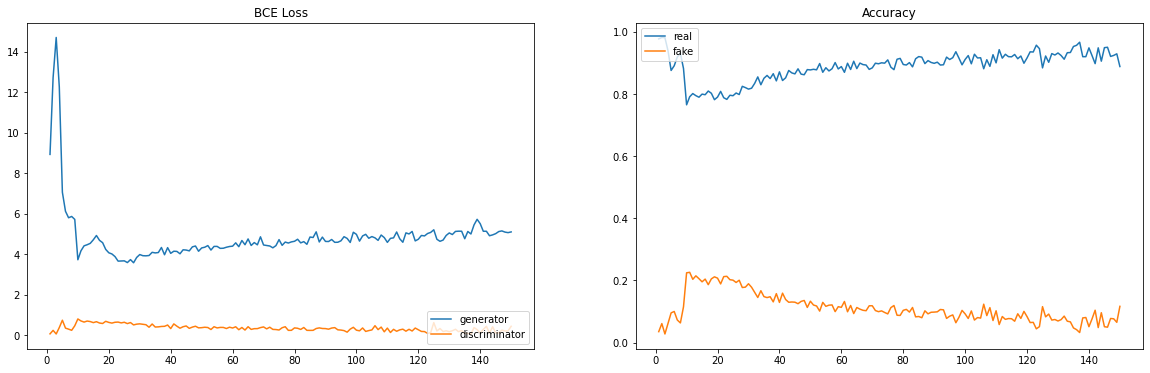

In [ ]:
# with open('history.pkl', 'wb') as handle:
#     pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(DATA_OUT + 'history.pkl', 'rb') as handle:
#     history = pickle.load(handle)
show_history(history)

### Генерация изображений

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


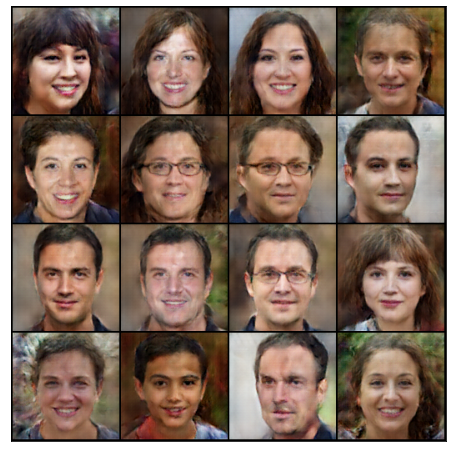

In [ ]:
N_IMAGES = 16
show_images(generate(model['generator'], N_IMAGES), size=(4, 4))

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
N_IMAGES = 1000

real_imgs = torch.Tensor()
for imgs, _ in dataloader:
    real_imgs = torch.cat([real_imgs, imgs])
    if real_imgs.shape[0] >= N_IMAGES:
        break

In [ ]:
labels = torch.cat([torch.ones(N_IMAGES), torch.zeros(N_IMAGES)])

# build model
model = KNeighborsClassifier(n_neighbors=1)

# define cross-validation method to use
cv = LeaveOneOut()

for epoch in [1, 3, 8, 20, 50, 80, 100, 120, 150]:
    # use LOOCV to evaluate model
    accuracies = cross_val_score(
        model, ts_data[epoch], labels, scoring='accuracy', cv=cv, n_jobs=-1
    )
    print(f'Epoch {epoch} mean accuracy: {accuracies.mean()}')

Epoch 1 mean accuracy: 1.0
Epoch 3 mean accuracy: 1.0
Epoch 8 mean accuracy: 1.0
Epoch 20 mean accuracy: 0.993
Epoch 50 mean accuracy: 0.93
Epoch 80 mean accuracy: 0.8845
Epoch 100 mean accuracy: 0.8135
Epoch 120 mean accuracy: 0.855
Epoch 150 mean accuracy: 0.806


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Accuracy стремиться от 1.  
1 - изображения отличаются полностью и их легко разделить на 2 класса.  
0.5 - соседом может быть как реальное изображение, так и сгенерированное.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

C:\Users\PTyCCa\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\PTyCCa\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\PTyCCa\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\PTyCCa\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\PTyCCa\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\PT

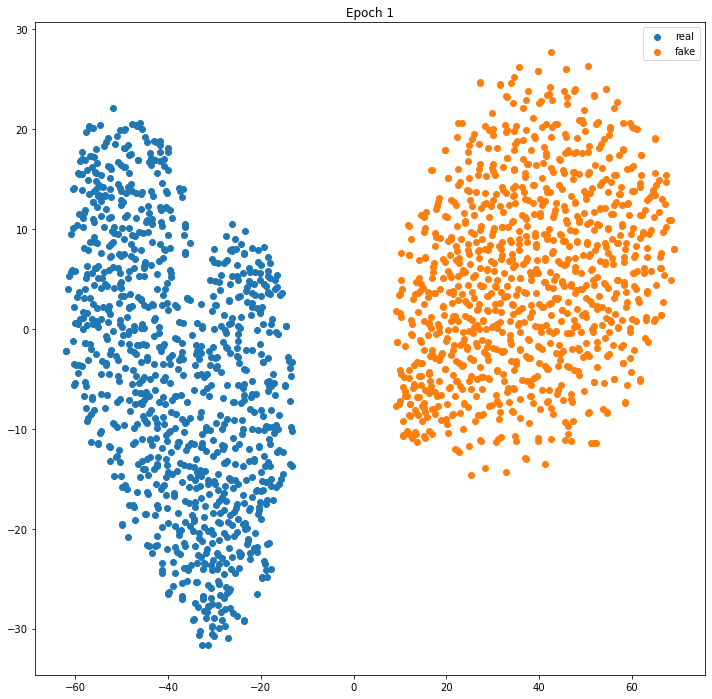

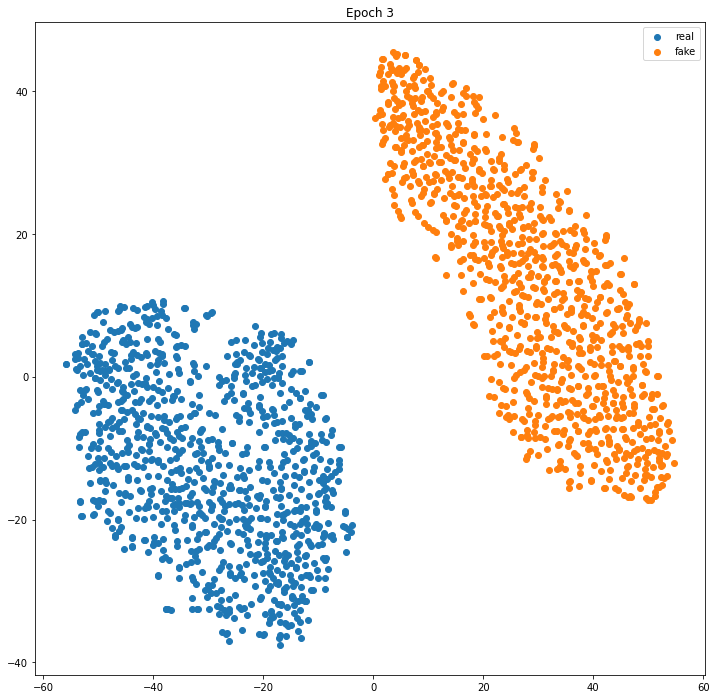

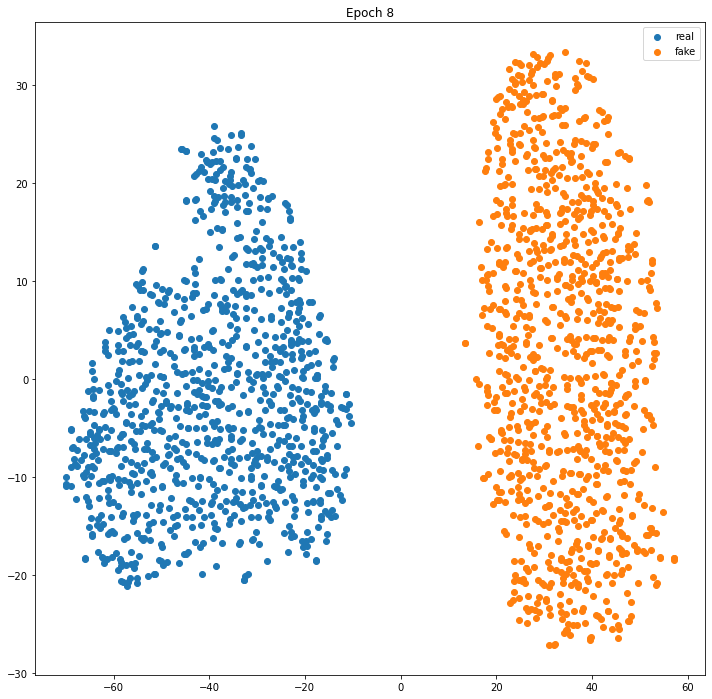

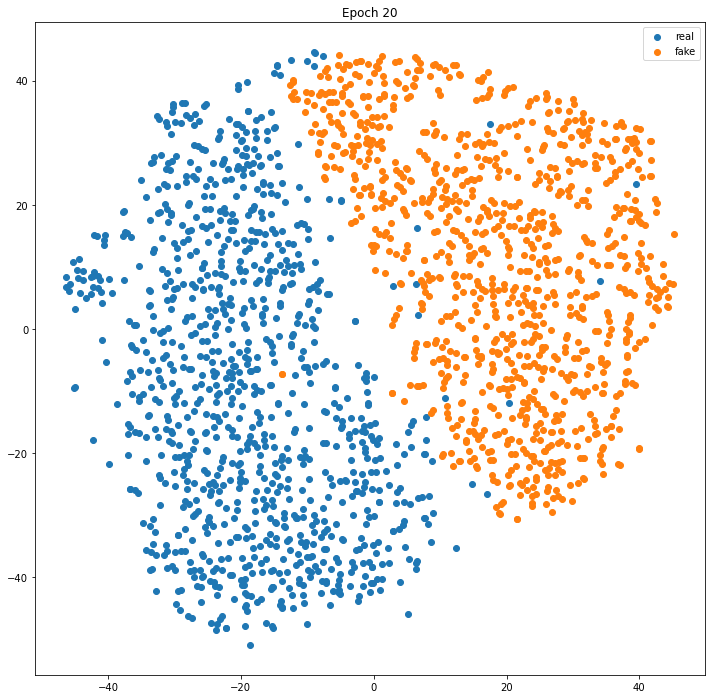

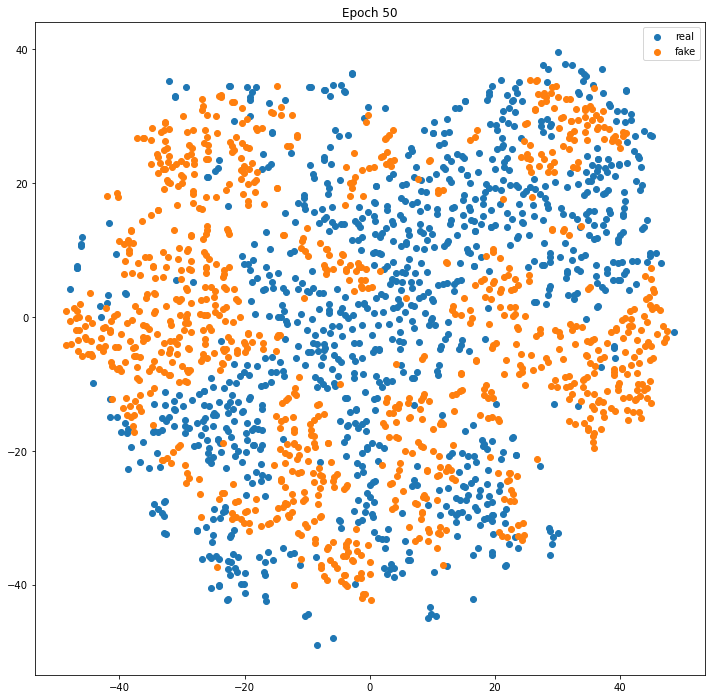

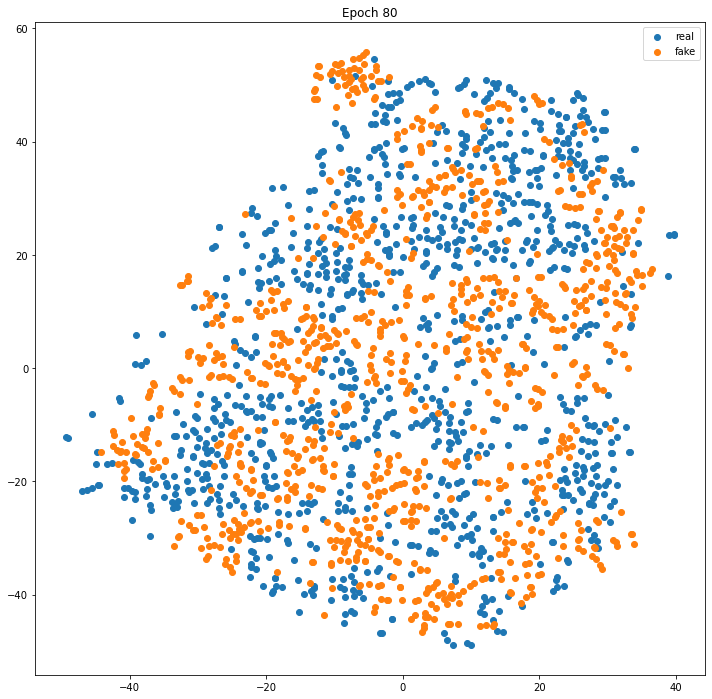

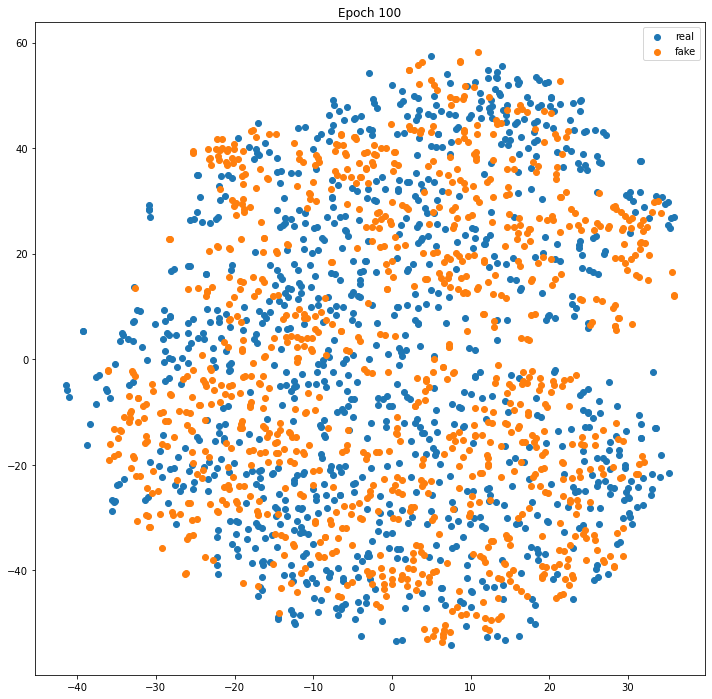

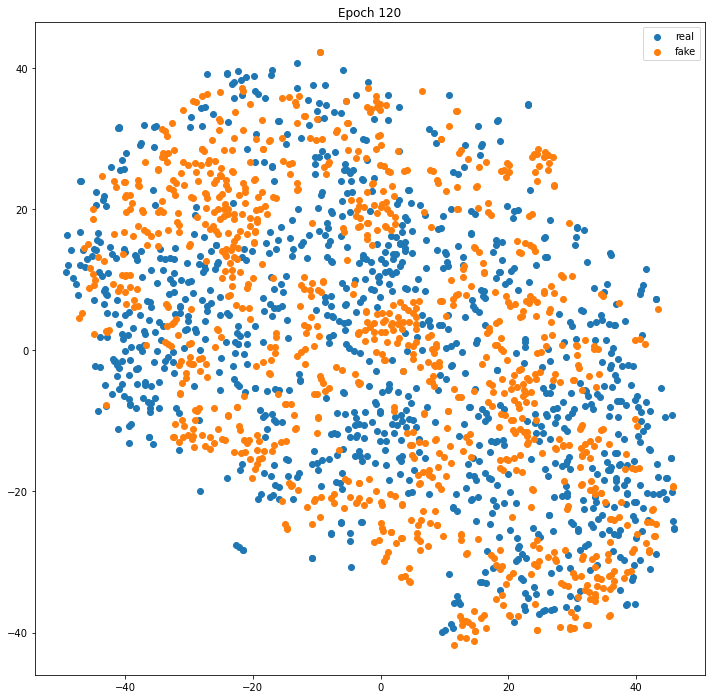

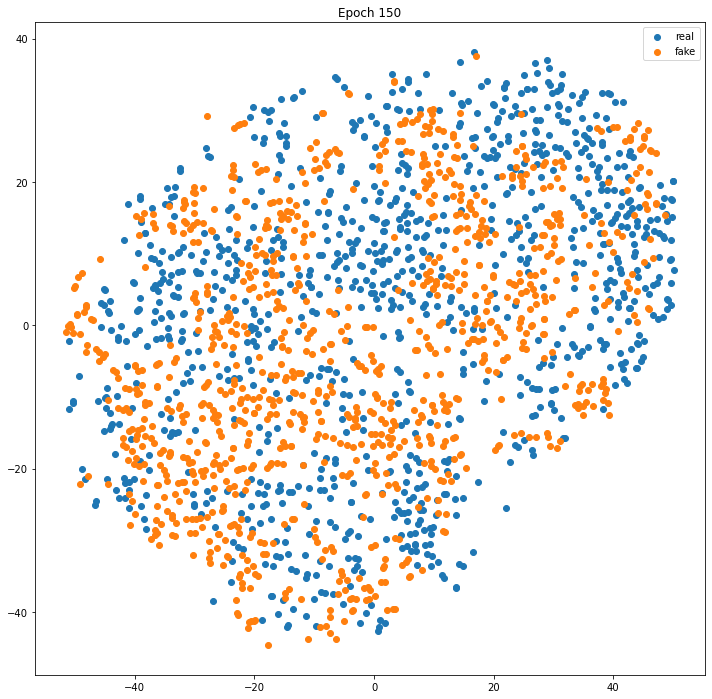

In [ ]:
ts_data = {}
for epoch in [1, 3, 8, 20, 50, 80, 100, 120, 150]:
    with open(f'imgs_epoch_{epoch}.pkl', 'rb') as handle:
        fake_imgs = pickle.load(handle)
    
    imgs_flatten = torch.cat([
        real_imgs.flatten(start_dim=1)[:N_IMAGES, :],
        fake_imgs.flatten(start_dim=1)[:N_IMAGES, :]
    ])
    
    ts = TSNE(random_state=42, verbose=0).fit_transform(imgs_flatten)

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.title(f'Epoch {epoch}')
    plt.scatter(ts[:N_IMAGES, 0], ts[:N_IMAGES, 1], label='real')
    plt.scatter(ts[N_IMAGES:, 0], ts[N_IMAGES:, 1], label='fake')
    plt.legend()
    
    ts_data[epoch] = ts

Прокомментируйте получившийся результат:

При идеальной генерации, облака будут совпадать, разделить их на два класса сложно. Форма сгенерированного распределения становится лучше.